# Seismic acquisition fiddling

This notebook is to accompany the blog post published on January 8, 2015: <a href="http://www.agilegeoscience.com/blog/2015/1/8/it-goes-in-the-bin">It goes in the bin</a> at <a href="www.agilegeoscience.com">Agile Geoscience</a>. 

The idea is to replicate what we've done so far but with 3 enhancements:

- With a Survey object to hold the various features of a survey.
- With more GeoPandas stuff, and less fussing with (x,y)'s directly.
- Making bins and assigning midpoints to them.

We'll start with the usual prelims...

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
import geopandas as gpd
import pandas as pd
# from fiona.crs import from_epsg

%matplotlib inline

## Survey object

In [18]:
class Survey:
    """
    A seismic survey.
    """

    def __init__(self, params):
        
        # Assign the variables from the parameter dict,
        # using dict.items() for Python 3 compatibility.
        for k, v in params.items(): 
            setattr(self, k, v)
          
        # These are just a convenience; we could use the
        # tuples directly, or make objects with attrs.
        self.xmi = self.corner[0]
        self.ymi = self.corner[1]
        
        self.x = self.size[0]
        self.y = self.size[1]
        
        self.SL = self.line_spacing[0]
        self.RL = self.line_spacing[1]
        
        self.si = self.point_spacing[0]
        self.ri = self.point_spacing[1]
        
        self.shiftx = -self.si/2.
        self.shifty = -self.ri/2.
           
    @property
    def lines(self):
        """
        Returns number of (src, rcvr) lines.
        """
        slines = int(self.x/self.SL) + 1
        rlines = int(self.y/self.RL) + 1
        return slines, rlines

    @property
    def points_per_line(self):
        """
        Returns number of (src, rcvr) points per line.
        """
        spoints = int(self.y/self.si) + 2
        rpoints = int(self.x/self.ri) + 2
        return spoints, rpoints
    
    @property
    def src(self):
        s = [Point(self.xmi+line*self.SL, self.ymi+s*self.si)
             for line in range(self.lines[0])
             for s in range(self.points_per_line[0])
             ]
        S = gpd.GeoSeries(s, crs=f"EPSG:{26911}")
        return S

    @property
    def rcvr(self):
        r = [Point(self.xmi + r*self.ri + self.shiftx, self.ymi + line*self.RL - self.shifty)
             for line in range(self.lines[1])
             for r in range(self.points_per_line[1])
             ]
        R = gpd.GeoSeries(r, crs=f"EPSG:{self.epsg}")
        return R
    
    @property
    def layout(self):
        """
        Provide a GeoDataFrame of all points,
        labelled as columns and in hierarchical index.
        """
        # Feels like there might be a better way to do this...
        sgdf = gpd.GeoDataFrame({'geometry': self.src, 'station': 'src'}, crs=f"EPSG:{self.epsg}")
        rgdf = gpd.GeoDataFrame({'geometry': self.rcvr, 'station': 'rcvr'}, crs=f"EPSG:{self.epsg}")

        # Concatenate with a hierarchical index
        layout = pd.concat([sgdf,rgdf], keys=['sources','receivers'])

        return layout

Perhaps s and r should be objects too. I think you might want to have survey.receivers.x for the list of x locations, for example.

## Instantiate and plot

In [19]:
params = {'corner': (5750000,4710000),
          'size': (3000,1800),
          'line_spacing': (600,600),
          'point_spacing': (100,100),
          'epsg': 26911 # http://spatialreference.org/ref/epsg/26911/
          }

survey = Survey(params)

In [20]:
s = survey.src
r = survey.rcvr
r[:10]

0    POINT (5749950 4710050)
1    POINT (5750050 4710050)
2    POINT (5750150 4710050)
3    POINT (5750250 4710050)
4    POINT (5750350 4710050)
5    POINT (5750450 4710050)
6    POINT (5750550 4710050)
7    POINT (5750650 4710050)
8    POINT (5750750 4710050)
9    POINT (5750850 4710050)
dtype: geometry

In [21]:
layout = survey.layout
layout[:10]

geometry station
sources 0  POINT (5750000 4710000)     src
        1  POINT (5750000 4710100)     src
        2  POINT (5750000 4710200)     src
        3  POINT (5750000 4710300)     src
        4  POINT (5750000 4710400)     src
        5  POINT (5750000 4710500)     src
        6  POINT (5750000 4710600)     src
        7  POINT (5750000 4710700)     src
        8  POINT (5750000 4710800)     src
        9  POINT (5750000 4710900)     src

With a hierarchical index you can do cool things, e.g. show the last five sources:

In [24]:
layout.loc['sources'][-5:]

,geometry,station
115,POINT (5753000 4711500),src
116,POINT (5753000 4711600),src
117,POINT (5753000 4711700),src
118,POINT (5753000 4711800),src
119,POINT (5753000 4711900),src


In [25]:
layout.crs

<Projected CRS: EPSG:26911>
Name: NAD83 / UTM zone 11N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - between 120°W and 114°W - onshore and offshore. Canada - Alberta; British Columbia; Northwest Territories; Nunavut. United States (USA) - California; Idaho; Nevada, Oregon; Washington.
- bounds: (-120.0, 30.88, -114.0, 83.5)
Coordinate Operation:
- name: UTM zone 11N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

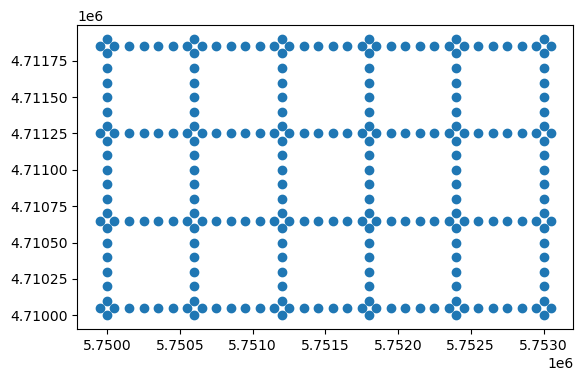

In [26]:
ax = layout.plot()

Export GeoDataFrames to GIS shapefile.

In [27]:
# gdf.to_file('src_and_rcvr.shp')

## Midpoint calculations

We need midpoints. There is a midpoint between every source-receiver pair.

Hopefully it's not too inelegant to get to the midpoints now that we're using this layout object thing.

In [29]:
midpoint_list = [LineString([r, s]).interpolate(0.5, normalized=True)
                  for r in layout.loc['receivers'].geometry
                  for s in layout.loc['sources'].geometry
                  ]

As well as knowing the (x,y) of the midpoints, we'd also like to record the distance from each *s* to each live *r* (each *r* in the live patch). This is easy enough to compute:

    Point(x1, y1).distance(Point(x2, y2))
 
Then we can make a list of all the offsets when we count the midpoints into the bins. 

In [30]:
offsets = [r.distance(s)
           for r in layout.loc['receivers'].geometry
           for s in layout.loc['sources'].geometry
           ]

In [31]:
azimuths = [(180.0/np.pi) * np.arctan((r.x - s.x)/(r.y - s.y))
            for r in layout.loc['receivers'].geometry
            for s in layout.loc['sources'].geometry
            ]

In [32]:
offsetx = np.array(offsets)*np.cos(np.array(azimuths)*np.pi/180.)
offsety = np.array(offsets)*np.sin(np.array(azimuths)*np.pi/180.)

Make a Geoseries of the midpoints, offsets and azimths:

In [33]:
midpoints = gpd.GeoDataFrame({
                   'geometry' : midpoint_list,
                   'offset' : offsets,
                   'azimuth': azimuths,
                   'offsetx' : offsetx,
                   'offsety' : offsety
                   })
midpoints[:5]

,geometry,offset,azimuth,offsetx,offsety
0,POINT (5749975 4710025),70.710678,-45.000000,50.0,-50.0
1,POINT (5749975 4710075),70.710678,45.000000,50.0,50.0
2,POINT (5749975 4710125),158.113883,18.434949,150.0,50.0
3,POINT (5749975 4710175),254.950976,11.309932,250.0,50.0
4,POINT (5749975 4710225),353.553391,8.130102,350.0,50.0


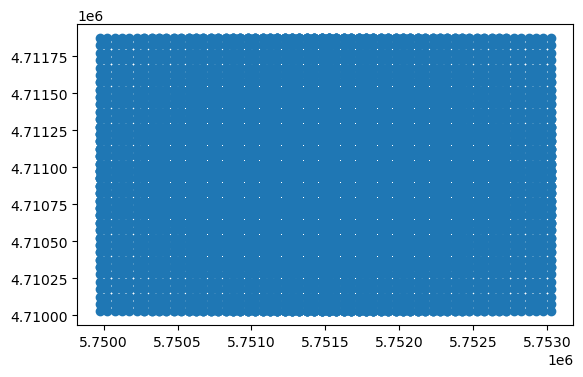

In [34]:
ax = midpoints.plot()

Save to a shapefile if desired. 

In [ ]:
#midpt.to_file('CMPs.shp')

## Spider plot

In [35]:
midpoints[:5].offsetx # Easy!

0     50.0
1     50.0
2    150.0
3    250.0
4    350.0
Name: offsetx, dtype: float64

In [36]:
midpoints.iloc[3].geometry.x # Less easy :(

5749975.0

We need lists (or arrays) to pass into the [matplotlib quiver plot](http://matplotlib.org/examples/pylab_examples/quiver_demo.html). This takes four main parameters: *x, y, u,* and *v*, where *x, y* will be our coordinates, and *u, v* will be the offset vector for that midpoint.

We can get at the GeoDataFrame's attributes easily, but I can't see how to get at the coordinates in the geometry GeoSeries (seems like a user error — it feels like it should be really easy) so I am resorting to this: 

In [37]:
x = [m.geometry.x for i, m in midpoints.iterrows()]
y = [m.geometry.y for i, m in midpoints.iterrows()]

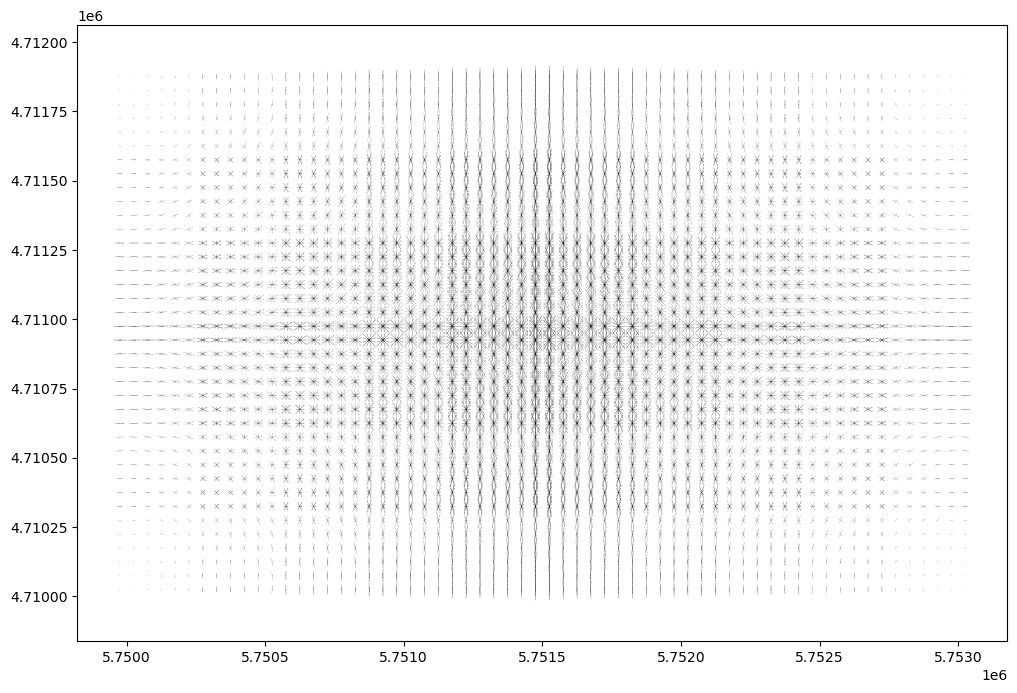

In [38]:
fig = plt.figure(figsize=(12,8))
plt.quiver(x, y, midpoints.offsetx, midpoints.offsety, units='xy', width=0.5, scale=1/0.025, pivot='mid', headlength=0)
plt.axis('equal')
plt.show()

## Bins

The bins are a new geometry, related to but separate from the survey itself, and the midpoints. We will model them as a GeoDataFrame of polygons. The steps are:

1. Compute the bin centre locations with our usual list comprehension trick.
1. Buffer the centres with a square.
1. Gather the buffered polygons into a GeoDataFrame.

In [39]:
# Factor to shift the bins relative to source and receiver points
jig = survey.si / 4.
bin_centres = gpd.GeoSeries([Point(survey.xmi + 0.5*r*survey.ri - jig, survey.ymi + 0.5*s*survey.si + jig)
                             for r in range(2*(survey.points_per_line[1]-1))
                             for s in range(2*(survey.points_per_line[0]-1))
                            ])

# Buffers are diamond shaped so we have to scale and rotate them.
scale_factor = np.sin(np.pi/4.)/2.
bin_polys = bin_centres.buffer(scale_factor*survey.ri, 1).rotate(-45)
bins = gpd.GeoDataFrame(geometry=bin_polys)

bins[:3]

,geometry
0,"POLYGON ((5750000 4710000, 5749950 4710000, 57..."
1,"POLYGON ((5750000 4710050, 5749950 4710050, 57..."
2,"POLYGON ((5750000 4710100, 5749950 4710100, 57..."


Suspect there's a super easy way to get all midpoints in a bin poly, without stepping over all bins.

**WARNING** This step is very slow for more than a few thousand midpoints. 

In [40]:
# Make a copy because I'm going to drop points as I
# assign them to polys, to speed up subsequent search.
midpts = midpoints.copy()

offsets, azimuths = [], [] # To hold complete list.

# Loop over bin polygons with index i.
for i, bin_i in bins.iterrows():
    
    o, a = [], [] # To hold list for this bin only.
    
    # Now loop over all midpoints with index j.
    for j, midpt_j in midpts.iterrows():
        if bin_i.geometry.contains(midpt_j.geometry):
            # Then it's a hit! Add it to the lists,
            # and drop it so we have less hunting.
            o.append(midpt_j.offset)
            a.append(midpt_j.azimuth)
            midpts = midpts.drop([j])
            
    # Add the bin_i lists to the master list
    # and go around the outer loop again.
    offsets.append(o)
    azimuths.append(a)
    
# Add everything to the dataframe.    
bins['offsets'] = gpd.GeoSeries(offsets)
bins['azimuths'] = gpd.GeoSeries(azimuths)

TypeError: Non geometry data passed to GeoSeries constructor, received data of dtype 'object'

In [ ]:
bins[:10]

,geometry,offsets,azimuths
0,"POLYGON ((5750000 4709999.999999999, 5749950 4...",[70.7106781187],[-45.0]
1,"POLYGON ((5750000 4710049.999999999, 5749950 4...",[70.7106781187],[45.0]
2,"POLYGON ((5750000 4710100, 5749950 4710100, 57...",[158.113883008],[18.4349488229]
3,"POLYGON ((5750000 4710150, 5749950 4710150, 57...",[254.95097568],[11.309932474]
4,"POLYGON ((5750000 4710200, 5749949.999999999 4...",[353.553390593],[8.13010235416]
5,"POLYGON ((5750000 4710250, 5749950 4710250, 57...",[452.769256907],[6.34019174591]
6,"POLYGON ((5750000 4710300, 5749950 4710300, 57...","[552.268050859, 651.92024052]","[5.19442890773, -4.398705355]"
7,"POLYGON ((5750000 4710349.999999999, 5749950 4...","[651.92024052, 552.268050859]","[4.398705355, -5.19442890773]"
8,"POLYGON ((5750000 4710400, 5749950 4710400, 57...","[751.664818919, 452.769256907]","[3.81407483429, -6.34019174591]"
9,"POLYGON ((5750000 4710450, 5749950 4710450, 57...","[851.469318296, 353.553390593]","[3.36646066343, -8.13010235416]"


We can compute the fold from the length of the list of offsets in each bin. We use a mini-function, called a [lambda](http://www.diveintopython.net/power_of_introspection/lambda_functions.html), to do this. This piece of code applies a lambda to each row in the GeoDataFrame. Essentially it says:

    set each row in the 'fold' column in my `bins` GeoDataFrame to the length of the offsets list for that row. 

In [ ]:
bins['fold'] = bins.apply(lambda row: len(row.offsets), axis=1)

Now we can use the GeoDataFrame's built-in `plot()` method to plot these:

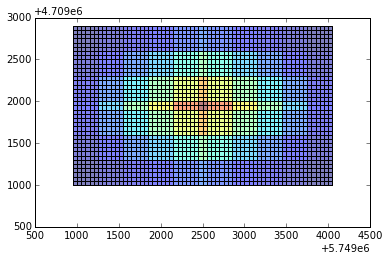

In [ ]:
ax = bins.plot(column="fold")

We can use a similar trick to compute the minimum offset, but with an added test for there being valid data in the bin:

In [ ]:
bins['min_offset'] = bins.apply(lambda row: min(row.offsets) if row.fold > 0 else None, axis=1)

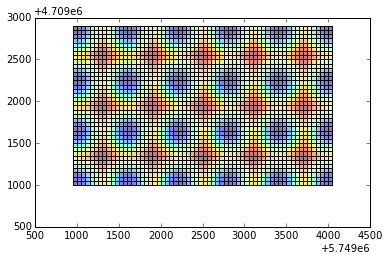

In [ ]:
ax = bins.plot(column="min_offset")